In [1]:
import sys
import pandas as pd
import numpy as np
import os
sys.path.append(os.path.abspath("../0_UTILITY_FUNCTIONS/"))
from get_LrLx_data import *
from clustering import *

For affinity propagation:
- Since it uses distances between points, highly correlated dimensions can dominate the distance calculations
- PCA can help create more meaningful distance metrics by decorrelating the features
- PCA can remove redundant information in correlated dimensions


This is not stricly necessary for GMMs.

# Run Tests on the Preprocessing Functions

In [2]:
## Get the data
df = get_all_LrLx_data_filtered(names = None, interp=True, rerun = False, save=False, incl_Fx_uplims = False, incl_Fr_uplims = False, type_source= "BH")

Source names:  ['1A 1744-361', '4U 1543-47', '4U 1630-47', 'Cen X-4', 'Cir X-1', 'EXO 1846-031', 'GRS 1739-278', 'GRS 1915+105', 'GX 339-4', 'H1743-322', 'IGR J17091-3624', 'MAXI J1348-630', 'MAXI J1631-479', 'MAXI J1803-298', 'MAXI J1807+132', 'MAXI J1810-222', 'MAXI J1816-195', 'MAXI J1820+070', 'SAX J1808.4-3658', 'SAX J1810.8-2609', 'Swift J1727.8-1613', 'Swift J1728.9-3613', 'Swift J1842.5-1124', 'Swift J1858.6-0814', 'Vela X-1', 'XTE J1701-462']
Sources included after filtering:  ['4U 1543-47' '4U 1630-47' 'EXO 1846-031' 'GRS 1739-278' 'GX 339-4'
 'H1743-322' 'IGR J17091-3624' 'MAXI J1348-630' 'MAXI J1631-479'
 'MAXI J1803-298' 'MAXI J1810-222' 'MAXI J1820+070' 'Swift J1727.8-1613'
 'Swift J1842.5-1124']


Number of data points: 195


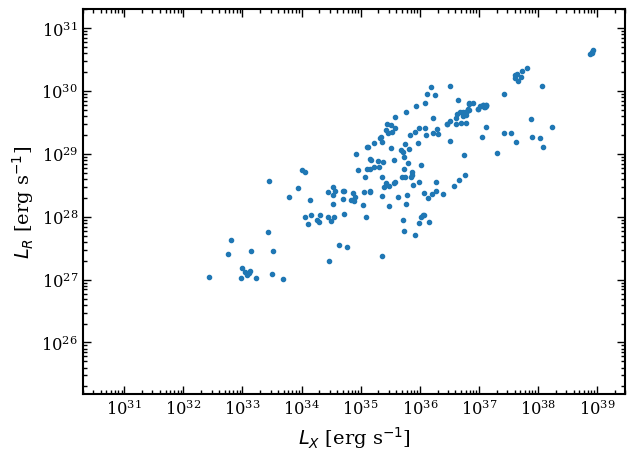

In [8]:
## Original data
Lr = df["Lr"].to_numpy()
Lx = df["Lx"].to_numpy()
print("Number of data points:", len(Lr))
data = np.column_stack((Lx, Lr))
plotLrLx(data)

[[-0.182498877986  0.577347422498]
 [ 0.12124175515   0.571852010307]
 [ 0.243038643249  0.655780290861]
 [ 0.169651049892  0.655705858649]
 [-0.305233874299  0.392997347613]]
Should be close to zero... [-1.324866142719e-14  8.357986667435e-15]
Should be close to one... [1. 1.]
[[-0.182968631345  0.578833518708]
 [ 0.121553832256  0.573323961289]
 [ 0.243664226377  0.65746827381 ]
 [ 0.170087732854  0.657393650009]
 [-0.306019548377  0.394008925471]]

Should be close to zero... [-6.376665577334e-17  2.060729169215e-16]
Should be close to one... [1.002574006832 1.002574006832]


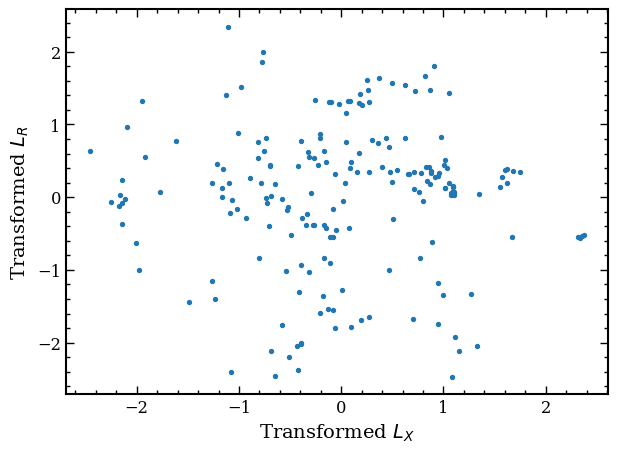

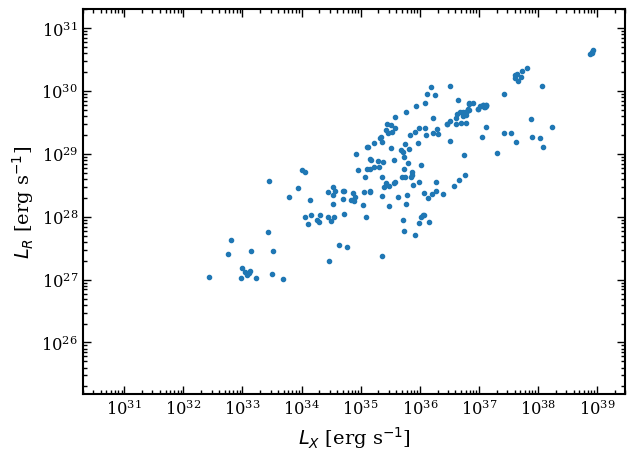

In [9]:
## CHECK THE TRANSFORMATION FUNCTION

## Transformed data
transformed_data, original_means, original_stds, pca, pca_data_mean, pca_data_std = transform1(data, testing=True)
plotLrLx_tranformed(transformed_data)

## Transform back to check
data_original = transform1_back(transformed_data, original_means, original_stds, pca, pca_data_mean, pca_data_std)
plotLrLx(data_original)

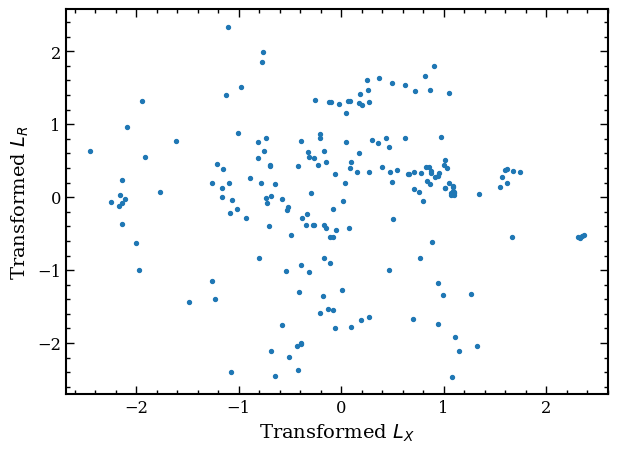

Difference between the two transformed datasets (should be close to zero): 0.006338932530594921


In [11]:
## CHECK THAT THE TRANSFORMATION FUNCTION IS EQUIVALENT TO PCA WITH WHITENING -- it is

transformed_data2 = transform1_alt(data, standardise=True)
plotLrLx_tranformed(transformed_data2)

print("Difference between the two transformed datasets (should be close to zero):", np.max(np.abs(transformed_data - transformed_data2)))

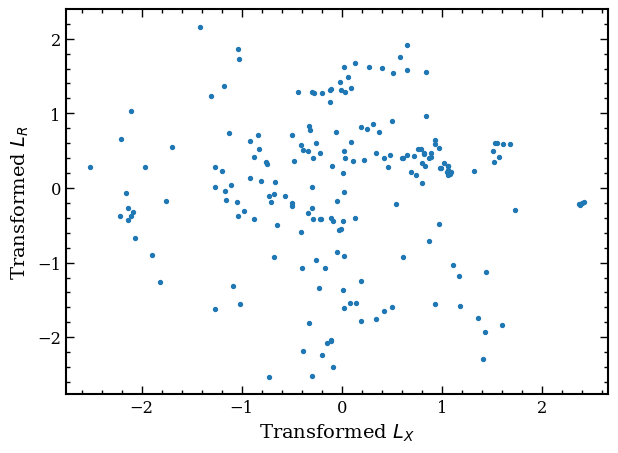

In [ ]:
## With PCA but no standardisation before -- we see that it does not make a big difference
transformed_data3 = transform1_alt(data, standardise=False)
plotLrLx_tranformed(transformed_data3)

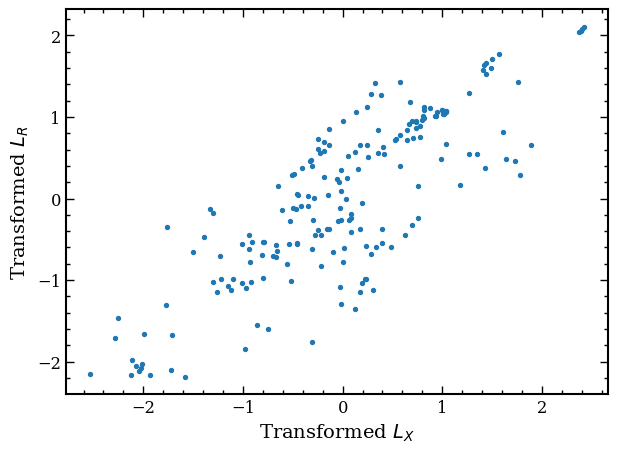

In [20]:
## With just standardisation 
transformed_data4 = standardise(data)
plotLrLx_tranformed(transformed_data4)

# Compare Clustering With and Without Standardisation

With standardisation and then PCA with whitening:
Estimated number of clusters: 2
Silhouette Coefficient: 0.512


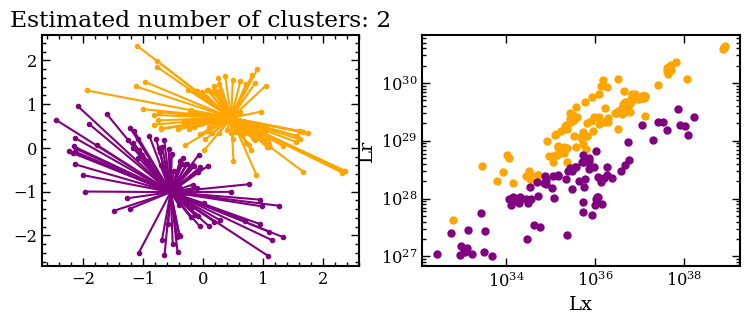

With just PCA with whitening:
Estimated number of clusters: 2
Silhouette Coefficient: 0.512


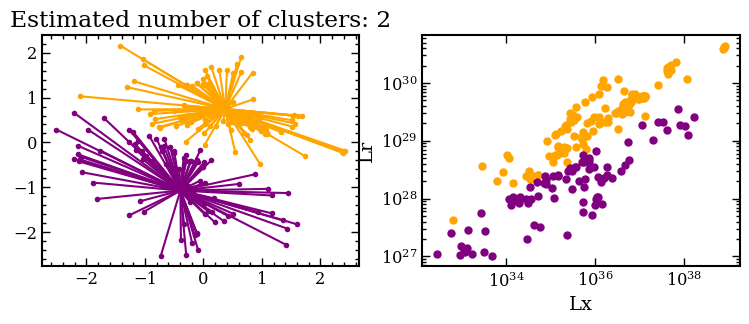

In [23]:
# With standardisation and then PCA with whitening
print("With standardisation and then PCA with whitening:")
_ = affinity_propagation(data, transformed_data2, preference=-100, damping =0.9, show_results2=False)


# With PCA 
print("With just PCA with whitening:")
_ = affinity_propagation(data, transformed_data3, preference=-100, damping =0.9, show_results2=False)

# Compare Clustering With and Without PCA

With standardisation and then PCA with whitening:
Estimated number of clusters: 2
Silhouette Coefficient: 0.512


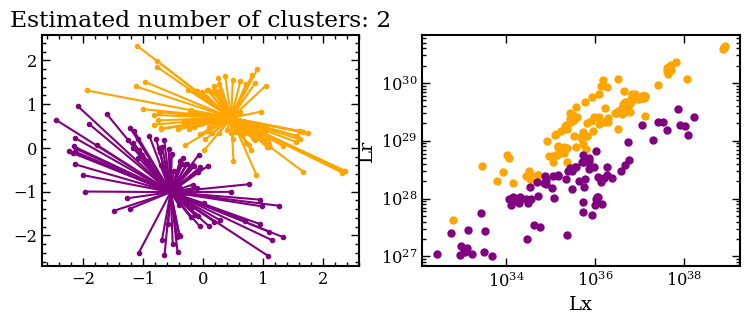

With just standardisation:
This will just cluster along the correlation.
Estimated number of clusters: 2
Silhouette Coefficient: 0.659


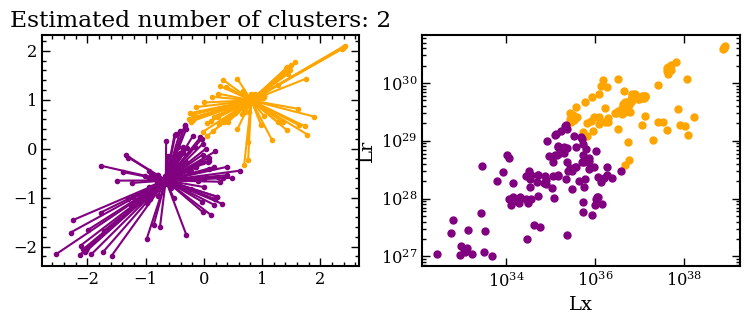

In [24]:
# With standardisation and then PCA with whitening
print("With standardisation and then PCA with whitening:")
_ = affinity_propagation(data, transformed_data2, preference=-100, damping =0.9, show_results2=False)


# With PCA 
print("With just standardisation:")
print("This will just cluster along the correlation.")
_ = affinity_propagation(data, transformed_data4, preference=-100, damping =0.9, show_results2=False)

# Sanity Check -- Comparing to the Pipeline Method

In [18]:
## Sanity check -- check using the pipeline method 

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def pipeline_method(data, preference=None, damping=0.5):

    Lx = data[:,0]
    Lr = data[:,1]

    # Log-transform
    log_Lx = np.log10(Lx)
    log_Lr = np.log10(Lr)

    logged_data = np.column_stack((log_Lx, log_Lr))

    # Build a pipeline: Standardise → PCA whitening → Affinity Propagation
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                          # center to zero mean & scale to unit variance
        ('pca', PCA(n_components=None, whiten=True)),           # decorrelate & unit-variance PCs
        ('ap', AffinityPropagation(affinity='euclidean',       # default negative squared Euclidean
                                    preference=preference,           # default: median similarity
                                    random_state=0, damping=damping))
    ])

    pipeline_pre = Pipeline([
        ('scaler', StandardScaler()),                          # center to zero mean & scale to unit variance
        ('pca', PCA(n_components=None, whiten=True)),           # decorrelate & unit-variance PCs
    ])

    # Fit to data matrix X (shape: [n_samples, n_features])
    pipeline.fit(logged_data)

    transformed_data = pipeline_pre.fit_transform(logged_data)

    # Extract labels and cluster centers
    cluster_centers_indices = pipeline.named_steps['ap'].cluster_centers_indices_
    labels = pipeline.named_steps['ap'].labels_         # array of cluster labels


    n_clusters_ = len(cluster_centers_indices)
    print("Estimated number of clusters: %d" % n_clusters_)

    if n_clusters_ > 1:
        silhouette = metrics.silhouette_score(transformed_data, labels, metric="sqeuclidean")
        print("Silhouette Coefficient: %0.3f" % silhouette)
    else:
        print("Only one cluster found. Silhouette score is not applicable.")


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
    colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_)))

    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = transformed_data[cluster_centers_indices[k]]
        ax1.scatter(
            transformed_data[class_members, 0], transformed_data[class_members, 1], color=col["color"], marker="."
        )
        ax1.scatter(
            cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
        )
        for x in transformed_data[class_members]:
            ax1.plot(
                [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"]
            )

    ax1.set_title("Estimated number of clusters: %d" % n_clusters_)
    ax2.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=5)

    ax2.set_xlabel("Lx")
    ax2.set_ylabel("Lr")
    ax2.set_yscale("log", base=10)
    ax2.set_xscale("log", base=10)
    plt.show()


With standardisation and then PCA with whitening:
Estimated number of clusters: 2
Silhouette Coefficient: 0.512


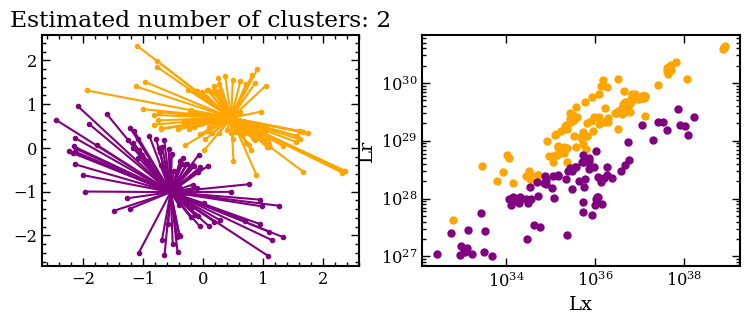

Using the pipeline method:
Estimated number of clusters: 2
Silhouette Coefficient: 0.512


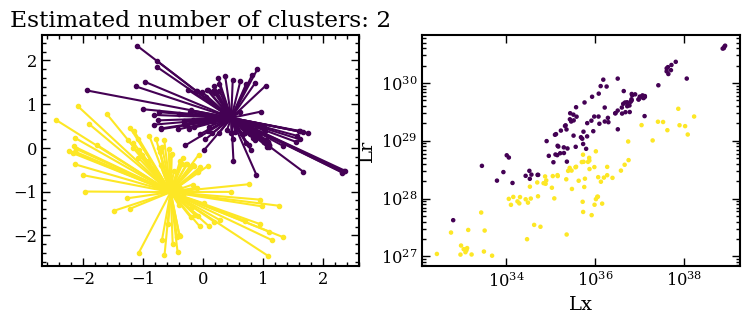

In [25]:
# With standardisation and then PCA with whitening
print("With standardisation and then PCA with whitening:")
_ = affinity_propagation(data, transformed_data2, preference=-100, damping =0.9, show_results2=False)

## Compare with pipeline method -- same as above
print("Using the pipeline method:")
pipeline_method(data, preference=-100, damping=0.9)